Для тюнинга гиперпараметров используется библиотека **Optuna** вместе с кроссвадидацией (TimeSeriesSplit).

## Импорт библиотек

In [2]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import random
import numpy as np
import pandas as pd
import optuna

from sklearn.ensemble import IsolationForest

from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error, root_mean_squared_error


from helper import divide_data, train_evaluate_models_cv
from plots import compare_metrics_heatmap

c:\Users\Kirill\Desktop\ML_Projects\ml-regression\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском
SEED = 42  # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

## 1. Препроцессинг данных

In [6]:
DATE_FEATURES_LIST = ["date"]

NUMERICAL_FEATURES_LIST = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "zipcode",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15",
    "year",
]

CATEGORICAL_FEATURES_LIST = [
    "waterfront",
    "view",
    "condition",
    "grade",
    "dayofweek",
    "quarter",
    "month",
    "is_month_start",
]

TARGET = "price"

In [7]:
df = pd.read_csv("./kc_house_data.csv")

In [8]:
df_preprocessed = df.copy()

# Преобразование строки в datetime
df_preprocessed["date"] = pd.to_datetime(
    df_preprocessed["date"], format="%Y%m%dT%H%M%S"
)

df_preprocessed["dayofweek"] = df_preprocessed["date"].dt.dayofweek
df_preprocessed["quarter"] = df_preprocessed["date"].dt.quarter
df_preprocessed["is_month_start"] = pd.to_numeric(
    df_preprocessed["date"].dt.is_month_start
)
df_preprocessed["is_month_start"] = df_preprocessed["is_month_start"].astype(int)
df_preprocessed["month"] = df_preprocessed["date"].dt.month
df_preprocessed["year"] = df_preprocessed["date"].dt.year

df_preprocessed = df_preprocessed.sort_values("date")
df_preprocessed = df_preprocessed.drop(columns=["date"])

# удаляем столбец customerID, поскольку он не несет пользы в дальнейшем исследовании
df_preprocessed = df_preprocessed.drop(columns=["id"])


iso = IsolationForest(contamination=0.1, random_state=SEED)
yhat = iso.fit_predict(df_preprocessed.drop(columns=[TARGET]))
mask = yhat != -1

df_preprocessed = df_preprocessed[mask]

df_preprocessed[TARGET] = np.log1p(df_preprocessed[TARGET])

In [9]:
X, y = divide_data(df_preprocessed, TARGET)

In [10]:
class SklearnCatBoostRegressor(CatBoostRegressor, BaseEstimator, RegressorMixin):
    """CatBoostRegressor совместимый со sklearn."""

    pass


base_model = (
    "model",
    SklearnCatBoostRegressor(
        random_state=SEED, verbose=0, task_type="CPU", allow_writing_files=False
    ),
)

In [11]:
cv = TimeSeriesSplit(n_splits=5)

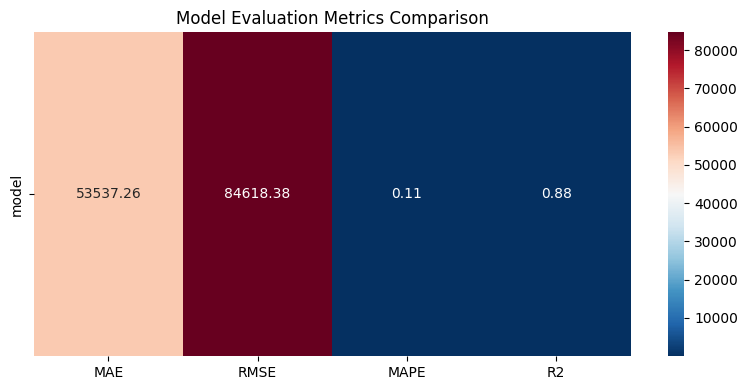

In [12]:
initial_metrics = train_evaluate_models_cv(
    models=[base_model],
    X=X,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
    use_log_target=True,
)

## 2. Подбор гиперпараметров

In [ ]:
def objective_pipeline(trial):
    use_gpu = False

    if use_gpu:
        border_count = 128
        task_type = "GPU"
    else:
        border_count = 254
        task_type = "CPU"

    bootstrap_type = trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
    )  # тип бутстрэпа (способ семплирования объектов при обучении)

    params = {
        "iterations": trial.suggest_int(
            "iterations", 500, 3000
        ),  # количество деревьев (итераций бустинга); влияет на силу модели и риск переобучения
        "depth": trial.suggest_int(
            "depth", 4, 10
        ),  # глубина деревьев; больше — сложнее зависимости, выше риск переобучения
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.005, 0.3, log=True
        ),  # шаг обучения; меньше — стабильнее и точнее, но требует больше деревьев
        "l2_leaf_reg": trial.suggest_float(
            "l2_leaf_reg", 1e-3, 30.0, log=True
        ),  # L2-регуляризация весов листьев; увеличивает устойчивость и снижает переобучение
        "min_data_in_leaf": trial.suggest_int(
            "min_data_in_leaf", 5, 200
        ),  # минимальное число объектов в листе; больше — более сглаженная модель
        "random_strength": trial.suggest_float(
            "random_strength", 0.0, 2.0
        ),  # уровень случайности при выборе сплитов; действует как регуляризация
        "rsm": trial.suggest_float(
            "rsm", 0.5, 1.0
        ),  # доля признаков для каждого дерева (feature sampling); снижает переобучение
        "bootstrap_type": bootstrap_type,  # метод семплирования объектов: Bayesian (взвешенный), Bernoulli (subsample), MVS (градиентный)
        "loss_function": trial.suggest_categorical(
            "loss_function", ["RMSE", "MAE"]
        ),  # функция потерь: RMSE — чувствителен к выбросам, MAE — устойчив к выбросам
        "od_type": "Iter",  # тип early stopping — остановка при отсутствии улучшения
        "od_wait": trial.suggest_int(
            "od_wait", 30, 200
        ),  # сколько итераций ждать улучшения перед остановкой
        "random_seed": SEED,
        "verbose": 0,
        "allow_writing_files": False,
        "border_count": border_count,
        "task_type": task_type,
    }

    # Зависимые параметры bootstrap
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0.0, 10.0
        )  # интенсивность байесовского бутстрэпа; больше — сильнее регуляризация

    elif bootstrap_type == "Bernoulli":
        params["subsample"] = trial.suggest_float(
            "subsample", 0.5, 1.0
        )  # доля объектов для каждого дерева; уменьшает переобучение и ускоряет обучение

    elif bootstrap_type == "MVS":
        params["subsample"] = trial.suggest_float(
            "subsample", 0.6, 1.0
        )  # доля объектов при градиентном семплинге; баланс скорости и точности

    mae_list = []
    rmse_list = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = SklearnCatBoostRegressor(
            **params, use_best_model=True, allow_writing_files=False
        )

        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)

        y_val = np.expm1(y_val)
        y_pred = np.expm1(model.predict(X_val))

        mae_list.append(mean_absolute_error(y_val, y_pred))
        rmse_list.append(root_mean_squared_error(y_val, y_pred))

    return np.mean(mae_list), np.mean(rmse_list)

In [60]:
# Запуск подбора гиперпараметров
study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective_pipeline, n_trials=150)


[I 2026-02-10 17:50:18,049] A new study created in memory with name: no-name-96be4573-63f5-4ae6-9a20-8ed04d035ce5
[I 2026-02-10 17:50:46,450] Trial 0 finished with values: [55392.5359131866, 87570.98061753248] and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 1036, 'depth': 9, 'learning_rate': 0.20990057649003185, 'l2_leaf_reg': 4.770164328632314, 'min_data_in_leaf': 156, 'random_strength': 0.3571524290971593, 'rsm': 0.9709291735900663, 'loss_function': 'RMSE', 'od_wait': 168, 'subsample': 0.5219902552973636}.
[I 2026-02-10 17:51:30,866] Trial 1 finished with values: [53717.17521475161, 86744.65539232621] and parameters: {'bootstrap_type': 'Bernoulli', 'iterations': 2704, 'depth': 6, 'learning_rate': 0.03541899626467519, 'l2_leaf_reg': 0.014879406871319561, 'min_data_in_leaf': 71, 'random_strength': 1.4722777735728014, 'rsm': 0.9660159789918992, 'loss_function': 'MAE', 'od_wait': 48, 'subsample': 0.714144227003173}.
[I 2026-02-10 17:51:53,958] Trial 2 finished with values: 

In [61]:
fig = optuna.visualization.plot_pareto_front(study)

fig.update_layout(xaxis_title="MAE", yaxis_title="RMSE")

fig.show()

In [62]:
optuna.visualization.plot_param_importances(study)

Самый важный гиперпараметр - bootstrap_type

In [66]:
best_trial_mae = min(study.best_trials, key=lambda t: t.values[0])
best_trial_rmse = min(study.best_trials, key=lambda t: t.values[1])

best_params_mae = best_trial_mae.params
best_params_rmse = best_trial_rmse.params

In [ ]:
# best_params_mae = {
#     "bootstrap_type": "Bernoulli",
#     "iterations": 2390,
#     "depth": 7,
#     "learning_rate": 0.026545629176856086,
#     "l2_leaf_reg": 0.10354243602548131,
#     "min_data_in_leaf": 197,
#     "random_strength": 1.5236018770721467,
#     "rsm": 0.5998574249658826,
#     "loss_function": "RMSE",
#     "od_wait": 195,
#     "subsample": 0.7210723822028944,
# }


# best_params_rmse = {
#     "bootstrap_type": "MVS",
#     "iterations": 1669,
#     "depth": 6,
#     "learning_rate": 0.07635918053104514,
#     "l2_leaf_reg": 5.142533035004691,
#     "min_data_in_leaf": 158,
#     "random_strength": 1.7962481199804916,
#     "rsm": 0.6978172821020538,
#     "loss_function": "RMSE",
#     "od_wait": 138,
#     "subsample": 0.9371407071033508,
# }

In [14]:
best_params_mae

{'bootstrap_type': 'Bernoulli',
 'iterations': 2390,
 'depth': 7,
 'learning_rate': 0.026545629176856086,
 'l2_leaf_reg': 0.10354243602548131,
 'min_data_in_leaf': 197,
 'random_strength': 1.5236018770721467,
 'rsm': 0.5998574249658826,
 'loss_function': 'RMSE',
 'od_wait': 195,
 'subsample': 0.7210723822028944}

In [15]:
best_params_rmse

{'bootstrap_type': 'MVS',
 'iterations': 1669,
 'depth': 6,
 'learning_rate': 0.07635918053104514,
 'l2_leaf_reg': 5.142533035004691,
 'min_data_in_leaf': 158,
 'random_strength': 1.7962481199804916,
 'rsm': 0.6978172821020538,
 'loss_function': 'RMSE',
 'od_wait': 138,
 'subsample': 0.9371407071033508}

In [ ]:
# Модель с подобранными гиперпараметрами минимизирующими MAE

best_model_mae = (
    "model",
    SklearnCatBoostRegressor(
        **best_params_mae,
        od_type="Iter",
        random_seed=SEED,
        verbose=0,
        allow_writing_files=False,
        border_count=254,
        task_type="CPU",
    ),
)

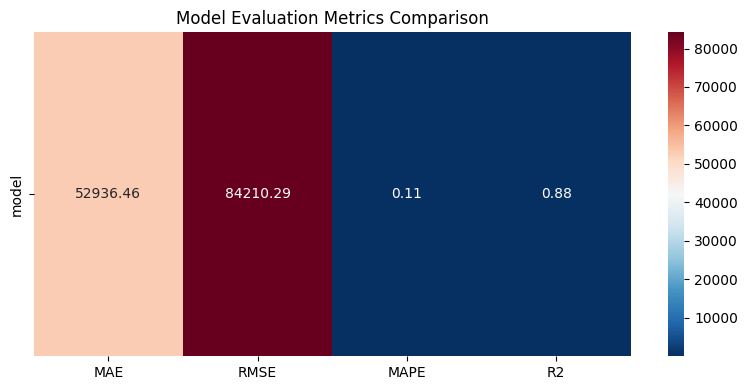

In [17]:
best_model_mae_metrics = train_evaluate_models_cv(
    models=[best_model_mae],
    X=X,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
    use_log_target=True,
)

In [ ]:
# Модель с подобранными гиперпараметрами минимизирующими RMSE

best_model_rmse = (
    "model",
    SklearnCatBoostRegressor(
        **best_params_rmse,
        od_type="Iter",
        random_seed=SEED,
        verbose=0,
        allow_writing_files=False,
        border_count=254,
        task_type="CPU",
    ),
)

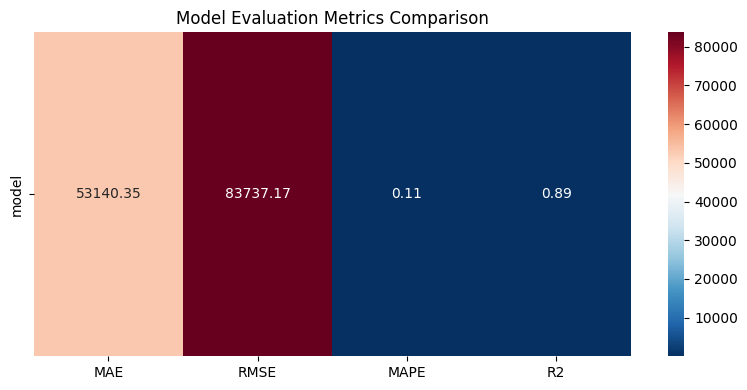

In [19]:
best_model_rmse_metrics = train_evaluate_models_cv(
    models=[best_model_rmse],
    X=X,
    y=y,
    preprocessor=None,
    cv=cv,
    seed=SEED,
    classification=False,
    use_log_target=True,
)

(<Figure size 800x400 with 2 Axes>,
             MAE      RMSE      MAPE        R2
 model  1.122204  0.482278  0.769639  0.131733)

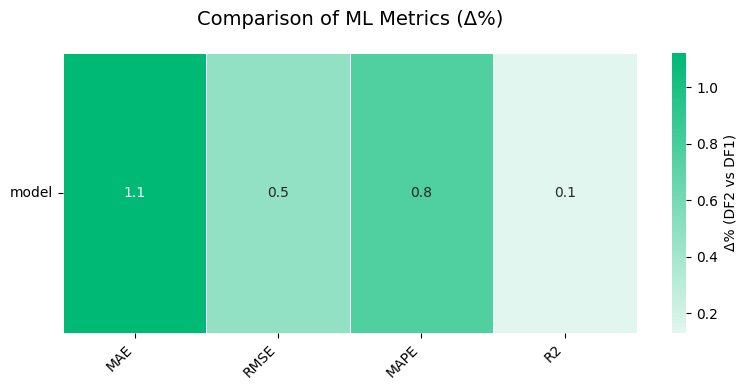

In [20]:
compare_metrics_heatmap(initial_metrics, best_model_mae_metrics)

(<Figure size 800x400 with 2 Axes>,
            MAE      RMSE     MAPE        R2
 model  0.74138  1.041395  0.26291  0.277449)

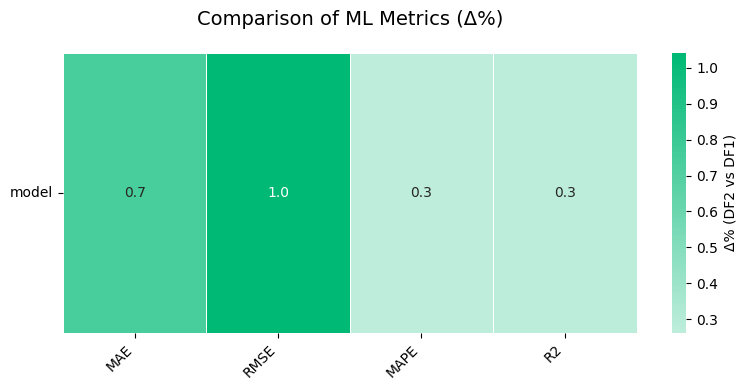

In [21]:
compare_metrics_heatmap(initial_metrics, best_model_rmse_metrics)

(<Figure size 800x400 with 2 Axes>,
             MAE      RMSE     MAPE        R2
 model -0.385146  0.561826 -0.51066  0.145525)

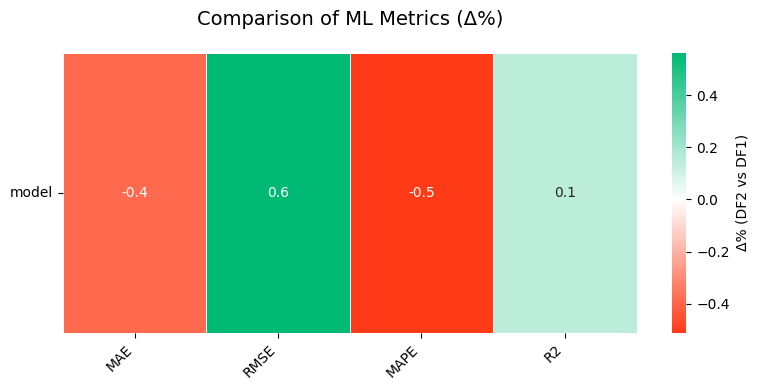

In [23]:
compare_metrics_heatmap(best_model_mae_metrics, best_model_rmse_metrics)

После подбора гиперпараметров минимизирующих MAE:
- MAE улучшился на 1.1%
- RMSE улучшился на 0.5%
- MAPE улучшился на 0.8%
- R2 практически не изменился

После подбора гиперпараметров минимизирующих RMSE:
- MAE улучшился на 0.7%
- RMSE улучшился на 1.0%
- MAPE и R2 улучшились на 0.3%


Если важна устойчивость к выбросам и крупным ошибкам, лучше оптимизировать RMSE.

Если важна средняя абсолютная точность прогноза, лучше оптимизировать MAE.